Из этого всего  вам не нужны только последние четыре импорта(пока что)

In [509]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, mannwhitneyu
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.svm import SVR
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

# Лютые и необходимые функции

In [510]:
def nan_to_median(series: pd.Series):
  median_val = series.median()
  return series.fillna(median_val)

def iqr_filter(df: pd.DataFrame, column: str, lower_bound=True, upper_bound=True, fill_nan=False, multp=3):
  """
  гибкая функция для удаления выбросов с помощью настраиваемого интерквартильного размаха

  Аргументы
      df: DataFrame содержащий данные, которые нужно отфильтровать.

      column: Название столбца в DataFrame df, в которомом будет производиться фильтрация.
      Функция будет рассчитывать IQR именно для этого столбца.

      lower_bound:  Булевый флаг, определяющий, следует ли отфильтровывать значения,
      лежащие ниже нижней границы, рассчитанной на основе IQR. То есть, если
      lower_bound = False, то все выбросы(если они есть) будут игнорироваться.

      upper_bound: Булевый флаг, определяющий, следует ли отфильтровывать значения,
      лежащие выше верхней границы, рассчитанной на основе IQR.

      multp: Множитель, используемый для расчета границ фильтрации.
  """
  df_copy = df.copy()

  if fill_nan:
    df_copy[column] = nan_to_median(df_copy[column])

  q1, q3 = np.percentile(df_copy[column], [25, 75])
  iqr = (q3 - q1) * multp
  low_bound = q1 - iqr
  up_bound = q3 + iqr

  median = 0 # медиана
  outlines = 0 # индексы, значения строк столбца которых необходимо заменить медианой

  # в этих ситуациях мы ищем медиану чисел, которые не считаем за выбросы (1)
  # то есть мы считаем за выбросы up_bound или/и low_bound и не используем их диапазон значений
  # для поиска медианы.
  if lower_bound and upper_bound:
    outlines = df_copy[(df_copy[column] < low_bound) | (df_copy[column] > up_bound)].index
    median = df_copy[(df_copy[column] >= low_bound) & (df_copy[column] <= up_bound)][column].median() # та самая медиана (1)
  elif lower_bound:
    outlines = df_copy[df_copy[column] < low_bound].index
    median = df_copy[df_copy[column] >= low_bound][column].median() # та самая медиана (1)
  elif upper_bound:
    outlines = df_copy[df_copy[column] > up_bound].index
    median = df_copy[df_copy[column] <= up_bound][column].median() # та самая медиана (1)

  df.loc[outlines, column] = median


####################################################################################################


def find_dependencies(correlation_matrix, threshold=0.5):
    """
    Выводит пары зависимых признаков на основе матрицы корреляции.

    Аргументы:
        correlation_matrix: Pandas DataFrame с матрицей корреляции.
        threshold: Порог корреляции для определения зависимости.
    """

    dependent_features = {} # словарь для хранения выявленных зависимостей.

    for feature in correlation_matrix.columns:  # цикл переберает все столбцы в матрице
        correlations = correlation_matrix[feature] # для текущей feature эта строка извлекает
                                                   # значения корреляции этой функции со всеми
                                                   # остальными функциями в виде pd.Series .
        dependencies = correlations[correlations.abs() >= threshold].index.tolist() # основная логика
        #correlations.abs() >= threshold: Это создаёт логическую маску, которая выбирает только
        #значения корреляции, которые по модулю абсолютного значения больше или равны threshold.
        #.index.tolist(): .index извлекает индексы (имена признаков), соответствующие
        #выбранным значениям корреляции, и .tolist() преобразует эти индексы в список.


        if dependencies:  # если есть зависимости
          dependencies.remove(feature) # удаляем зависимость с самим собой
          dependent_features[feature] = dependencies # выявленные зависимости сохраняются
                                                     # в словаре dependent_features.
                                                     # Текущий признак становится ключом,
                                                     # а список его зависимостей — значением.
    return dependent_features # пары зависимых признаков на основе матрицы корреляции.


####################################################################################################


def visualize_correlation_matrix(correlation_matrix, title="The best graphic"): # красивый график ВСЕХ корреляций(колличественных)
    """
    Рисует график корреляций всех колличественных признаков(и не только, если надо).

    Аругменты:
        correlation_matrix:  Фрейм данных Pandas, представляющий корреляционную матрицу.
        threshold: Название графика.
    """
    for col in correlation_matrix.columns: # цикл повторяется по каждому столбцу корреляционной матрицы.
        correlation_matrix[col] = pd.to_numeric(correlation_matrix[col], errors='coerce') # спасает от вылета программы.

    #correlation_matrix_np = correlation_matrix.values # преобразует фрейм данных Pandas в массив NumPy

    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest') # создание тепловой карты корреляций

    plt.colorbar(label='Correlation')

    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)

    plt.title(title)
    plt.show()


####################################################################################################



def super_train_test_split(df: pd.DataFrame, y: pd.Series):
  '''
  Делит данные на две выборки: 1. строки, значения необходимого нам столбца не имеют пропусков.
                               2. строки, значения необходимого нам столбца имеют пропуски.
  Каждый из этих пунктов так же делиться на две выборки: а) необходимый столбец.
                                                         б) остальные факторы.

  Аргументы:
    df: Pandas DataFrame, состоящий из факторов, инмеющих зависимость с признаком,
        в котором необходимо заполнить пропуски.

    y: Pandas Series, признак, пропуски которого необходимо заполнить.

  небольшой комментарий:
  У нас есть проблема - для заполенния пропусков с помощью какой-либо модели, необходимо,
  чтобы ВСЕ значения в других признаках были заполнены(не было пропусков).
  В противном случае модель ругается, что есть NaNы. Данный цикл устраняет данную проблему,
  временно заполняя пропуски в столбцах на медиану всех значений признака
  (кроме столбца, задача для которого изначально была заполнить пропуски с помощью модели).
  Дальше смотрите по комментариям
  '''
  X = df.copy()

  for col in X.columns: # временно заменяем пропуски в зависимых факторах на медиану
    if X[col].isnull().any() == True:
      median_value = X[col].median()
      X[col] = X[col].fillna(median_value)


  y_train = y[y.isnull() == False] # отбираем для тренировки те строки, в которых присутсвуют данные
  y_temp = y[y.isnull()] # просто мусор. Полезный

  idxs = y_temp.index # берём иднексы мусора(индексы,
                      # в строках которых есть пропуски, которые необходимо заполнить)
  X_train = X.drop(idxs) # делаем обучающую выборку из строк, в которых нет пропусков

  idxs = y_train.index # берём иднексы c изначально заполенными значениями
  X_test = X.drop(idxs) # отбрасываем строки с заполненными значениями в нужном нам столбце.
                        # Получается выборка с данными, на основе которых будут
                        # предсказываться пропущенные значения

  return X_train, X_test, y_train, y_temp


####################################################################################################


def split_for_grade(df: pd.DataFrame, target_column: pd.Series): # без комментариев, это вам не пригодится
  X = df.copy()

  y = target_column

  y1 = y[y.isnull() == False] # отбираем для тренировки те строки, в которых присутсвуют данные
  y_temp = y[y.isnull()] # просто мусор. Полезный

  idxs = y_temp.index # берём иднексы мусора(индексы,
                      # в строках которых есть пропуски, которые необходимо заполнить)
  X = X.drop(idxs) # делаем обучающую выборку из строк, в которых нет пропусков
  for col in X.columns:
    if X[col].isnull().any() == True:
      median_value = X[col].median()
      X[col] = X[col].fillna(median_value)

  X_train, X_test, y_train, y_test = train_test_split(
    X, y1, test_size=round(len(y_temp) / len(y1), 10), random_state=42)
  return X_train, X_test, y_train, y_test

# База

инициализация регрессионных моделей и т.п.

In [511]:
random_forest_model = RandomForestRegressor(random_state=42)
linear_regression = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=3)
gbm = xgb.XGBRegressor(objective='reg:squarederror',  # Objective function for regression
                       n_estimators=100,          # Number of trees (adjust as needed)
                       max_depth=3,               # Maximum depth of each tree (adjust as needed)
                       learning_rate=0.1,        # Learning rate (adjust as needed)
                       random_state=42)
svr_reg = SVR(kernel='rbf', C=100, gamma=0.1) # параметры нужно подбирать
decision_tree = DecisionTreeRegressor(random_state=42)

In [512]:
df_environmental_data = pd.read_csv("analysing_environmental_issues.csv", sep=',') # главный датафрейм

In [513]:
#df_environmental_data

# Проверка корреляции признаков
данные сырые, поэтому после предобработки будут нуждаться в повторной проверке

подготавливаем копию главного датафрейма. Он послужит нам для анализа корреляции между признаками

In [514]:
df2 = df_environmental_data.copy() # копируем главый датафрейм.
df2["DateTime"] = pd.factorize(df2["DateTime"])[0] # Меняем значения столбца на индекс
                                                   # для адекватной работы с этим признаком.
df2.pop("stage_4_output_danger_gas") # значений мало, признак на данном этапе бесполезный.

df2 = df2.drop_duplicates(subset=df2.columns[1:], keep=False) # удаляем все дупликаты.
# Очень важно, что дубликаты будут найдены, если игнорировать столбец "DateTime".

columns_without_nan = [col for col in df2.columns if df2[col].isnull().any() == False]
# Массив с назаниями признаков, в которых НЕТ пропусков значений в датафрейме(без предобработки).

#print(df2.shape) # (4240, 23)

for col in df2.columns: # замена пропусков медианой в каждом столбце
      if df2[col].isnull().any():
        median_val = df2[col].median()
        df2[col] = df2[col].fillna(median_val)

for i in df2.columns[1:]:
  iqr_filter(df2, i, fill_nan=True, multp=1.5)
#columns_without_nan
#df2["DateTime"]

In [515]:
columns = df2.columns[:-1] # создаём переменную с названиями признаков,
                           # кроме "work_shift", т.к. это бинарный фактор

correlation_matrix_spearman = pd.DataFrame(index=columns, columns=columns) # создаём типо матрицу, корреляцию признаков
                                                                           # которой будем искать методом спирмена.

In [516]:
for chunk in pd.read_csv("analysing_environmental_issues.csv", sep=',', chunksize=750): # считываем все данные
                                                                                        # порциями по 750 строк
  for col in chunk.columns[1:-1]: # замена пропусков медианой в каждом столбце
      median_val = chunk[col].median()
      chunk[col] = chunk[col].fillna(median_val)

  for col1 in columns: # вычисление коэффициентов корелляции для всех пар столбцов
        for col2 in columns:
            corr_spearman, p_value_spearman = spearmanr(chunk[col1], chunk[col2])

            correlation_matrix_spearman.loc[col1, col2] = corr_spearman
            #устанавливаем в качестве значения коэффициенты корреляции в нужную ячейку

**chunksize** делит генеральную совокупность на выборки по 750 строк. Это поможет создать более динамические значения на месте пропусков. То есть пропуски заменяются не на **медиану генеральной совокупности**, а на **медианы выборок**.

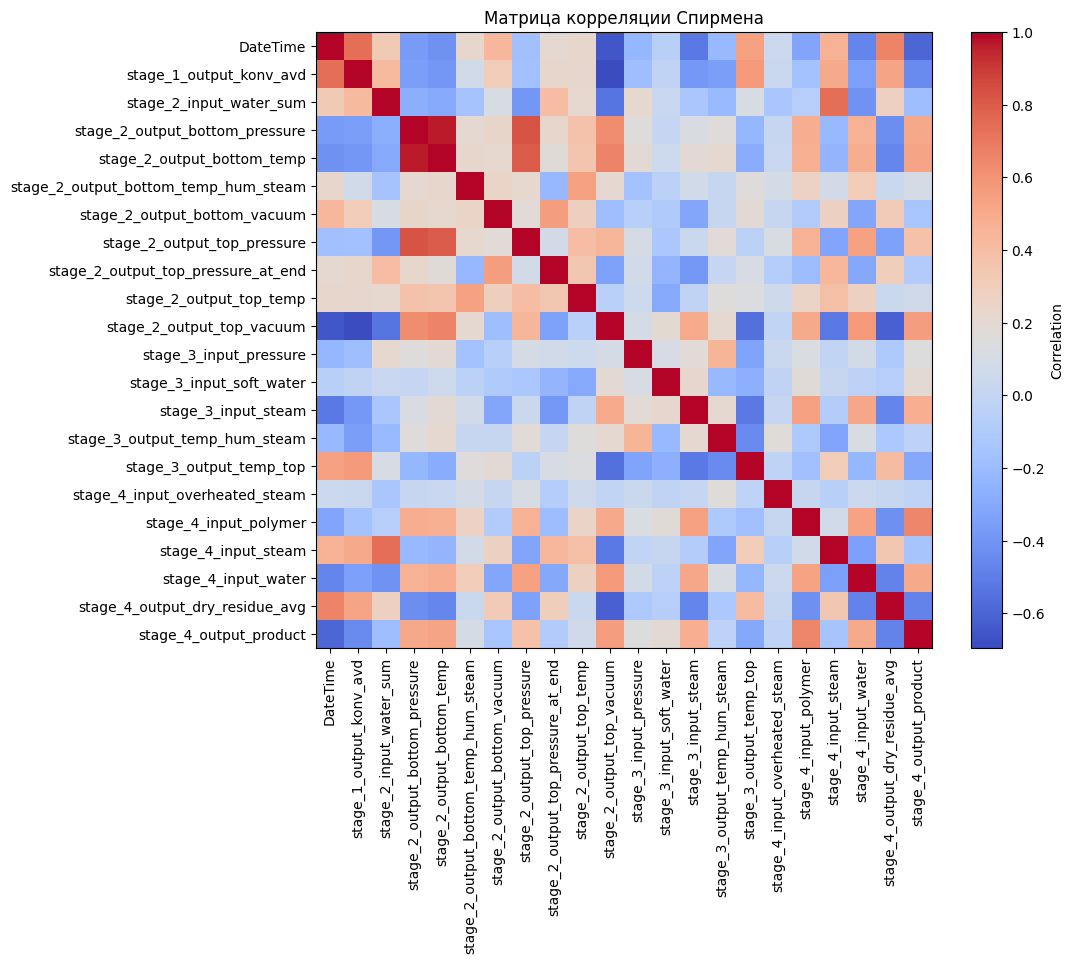

In [517]:
visualize_correlation_matrix(correlation_matrix_spearman, 'Матрица корреляции Спирмена')

In [518]:
dependencies_columns = {}

In [519]:
spearman_dependencies = find_dependencies(correlation_matrix_spearman, threshold=0.5)

print("\nЗависимости Спирмена (порог 0.6):\n")
print("-"*150)
for feature, deps in spearman_dependencies.items():
  if feature not in columns_without_nan and deps != []:
    dependencies_columns[feature] = deps

  print(f"| {feature}: {deps}", ' '*(143 - len(feature) - len(str(deps))), "|")
  print("-"*150)


Зависимости Спирмена (порог 0.6):

------------------------------------------------------------------------------------------------------------------------------------------------------
| DateTime: ['stage_1_output_konv_avd', 'stage_2_output_top_vacuum', 'stage_3_input_steam', 'stage_3_output_temp_top', 'stage_4_output_dry_residue_avg', 'stage_4_output_product']  |
------------------------------------------------------------------------------------------------------------------------------------------------------
| stage_1_output_konv_avd: ['DateTime', 'stage_2_output_top_vacuum', 'stage_3_output_temp_top', 'stage_4_input_steam', 'stage_4_output_dry_residue_avg']  |
------------------------------------------------------------------------------------------------------------------------------------------------------
| stage_2_input_water_sum: ['stage_2_output_top_vacuum', 'stage_4_input_steam']                                                                      |
----------------------

In [520]:
binary_feature = 'work_shift'  # бинарный признак :D

quantitative_features = df2.columns[1:-1]
results = {}

for feature in quantitative_features:
  group1 = df2[df2[binary_feature] == 1.0][feature] # группа с 0
  group2 = df2[df2[binary_feature] == 2.0][feature] # группа с 1

  statistic, p_value = mannwhitneyu(group1, group2)
  results[feature] = {'statistic': statistic, 'p_value': p_value}

  if p_value < 0.05:
    if feature not in columns_without_nan:
      if feature not in dependencies_columns:
          dependencies_columns[feature] = [binary_feature]
      else:
        dependencies_columns[feature].append(binary_feature)


# Вывод результатов:
print("Результаты теста Манна-Уитни:")
for feature, res in results.items():
  print(f"{feature}: statistic={res['statistic']:.2f}, p-value={res['p_value']:.3f}")



# Визуализация (пример для одного признака):
#feature_to_visualize = 'stage_2_input_water_sum'  # Выберите признак для визуализации
#plt.figure(figsize=(8, 6))
#sns.boxplot(x=binary_feature, y=feature_to_visualize, data=df2)
#plt.title(f'Boxplot {feature_to_visualize} по группам {binary_feature}')
#plt.show()

#df2

Результаты теста Манна-Уитни:
stage_1_output_konv_avd: statistic=2217632.00, p-value=0.498
stage_2_input_water_sum: statistic=2349869.00, p-value=0.008
stage_2_output_bottom_pressure: statistic=2269382.50, p-value=0.534
stage_2_output_bottom_temp: statistic=2182869.50, p-value=0.121
stage_2_output_bottom_temp_hum_steam: statistic=2272782.50, p-value=0.479
stage_2_output_bottom_vacuum: statistic=2048094.00, p-value=0.000
stage_2_output_top_pressure: statistic=2236890.00, p-value=0.846
stage_2_output_top_pressure_at_end: statistic=2227450.50, p-value=0.667
stage_2_output_top_temp: statistic=2340946.00, p-value=0.015
stage_2_output_top_vacuum: statistic=2219121.00, p-value=0.522
stage_3_input_pressure: statistic=2353137.50, p-value=0.006
stage_3_input_soft_water: statistic=2102968.00, p-value=0.000
stage_3_input_steam: statistic=2225961.50, p-value=0.640
stage_3_output_temp_hum_steam: statistic=2127815.50, p-value=0.003
stage_3_output_temp_top: statistic=2253393.50, p-value=0.825
stage_4_

In [521]:
dependencies_columns

{'stage_1_output_konv_avd': ['DateTime',
  'stage_2_output_top_vacuum',
  'stage_3_output_temp_top',
  'stage_4_input_steam',
  'stage_4_output_dry_residue_avg'],
 'stage_2_input_water_sum': ['stage_2_output_top_vacuum',
  'stage_4_input_steam',
  'work_shift'],
 'stage_2_output_bottom_pressure': ['stage_2_output_bottom_temp',
  'stage_2_output_top_pressure',
  'stage_2_output_top_vacuum',
  'stage_4_output_product'],
 'stage_2_output_bottom_temp': ['stage_2_output_bottom_pressure',
  'stage_2_output_top_pressure',
  'stage_2_output_top_vacuum',
  'stage_4_output_product'],
 'stage_2_output_bottom_temp_hum_steam': ['stage_2_output_top_temp'],
 'stage_2_output_bottom_vacuum': ['stage_2_output_top_pressure_at_end',
  'work_shift'],
 'stage_2_output_top_pressure': ['stage_2_output_bottom_pressure',
  'stage_2_output_bottom_temp',
  'stage_4_input_water'],
 'stage_2_output_top_pressure_at_end': ['stage_2_output_bottom_vacuum'],
 'stage_2_output_top_temp': ['stage_2_output_bottom_temp_hum_s

**dependencies_columns** - это всё, что нам нужно было получить в разделе "проверка корреляции признаков".

**ОЧЕНЬ ВАЖНО**
эта хрень не показывает точную зависимость. Конечно, если коэффициент корреляции приблизительно равен 0.8, то зависимость есть. Каждую зависимость, которую выдал код я потом лично проверял. Так что можете обращаться ко мне

# Замена попусков

Просто копия главного датафрейма для экспериментов

In [522]:
df = df_environmental_data.copy()

Регрессионным моделям не нравится столбец DateTime, поэтому я его пока что просто удалил, но можно поставить в качестве индекса. DateTime сам по себе не очень полезен(на этапе предобработки).   

In [523]:
df["DateTime"] = pd.factorize(df["DateTime"])[0]

df.pop("stage_4_output_danger_gas") # значений мало, признак на данном этапе бесполезный.

df = df.drop_duplicates(subset=df.columns[1:], keep=False) # удаляем все дупликаты.
# Очень важно, что дубликаты будут найдены, если игнорировать столбец "DateTime".

In [524]:
df.describe()

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
count,4240.000000,4159.000000,4177.000000,4180.000000,4209.000000,4223.000000,4169.000000,4218.000000,4226.000000,4196.000000,...,4227.000000,4226.000000,4170.000000,4231.000000,4174.000000,4156.000000,4159.000000,4240.000000,4240.000000,4240.000000
mean,2174.773113,69.456160,86.674616,404.030844,79.215959,98.476441,56.764406,450.264177,261.478121,94.630858,...,875.691462,109.998318,42.777156,153.448811,20.162808,5.402151,313.779618,22.438208,46.346776,1.483019
std,1273.723768,4.032077,31.155280,62.018933,3.027407,8.890578,7.858853,72.004423,43.201651,4.541636,...,305.804871,2.783694,4.472304,1.759867,3.080904,1.074238,104.519417,1.243364,13.022949,0.499770
min,0.000000,50.330000,19.950000,248.760000,66.130000,79.590000,34.070000,260.220000,134.920000,81.050000,...,134.750000,102.330000,25.940000,110.040000,-0.170000,2.350000,65.260000,17.280000,0.710000,1.000000
25%,1059.750000,67.030000,64.820000,353.252500,77.430000,91.450000,52.250000,407.800000,230.027500,93.550000,...,656.695000,108.320000,40.960000,152.330000,18.100000,4.740000,245.160000,21.680000,40.065000,1.000000
50%,2167.500000,70.030000,82.900000,389.395000,78.820000,97.200000,56.070000,436.960000,259.660000,95.530000,...,844.150000,109.265000,44.100000,153.210000,20.510000,5.500000,303.390000,22.580000,47.870000,1.000000
75%,3274.250000,72.330000,105.570000,458.350000,80.850000,103.155000,60.030000,475.602500,290.480000,97.620000,...,1144.395000,111.067500,45.860000,153.835000,22.130000,6.140000,366.005000,23.280000,55.310000,2.000000
max,4399.000000,79.830000,233.370000,897.290000,105.460000,130.930000,125.360000,1000.750000,579.640000,109.900000,...,1616.930000,123.500000,53.650000,157.680000,31.460000,7.980000,725.740000,25.480000,107.050000,2.000000


In [525]:
for col in df.columns[1:-1]:
  iqr_filter(df, col, fill_nan=True, multp=3)

df.describe()

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
count,4240.000000,4159.000000,4177.000000,4180.000000,4209.000000,4223.000000,4169.000000,4218.000000,4226.000000,4196.000000,...,4227.000000,4226.000000,4170.000000,4231.000000,4174.000000,4156.000000,4159.000000,4240.000000,4240.000000,4240.000000
mean,2174.773113,69.470250,86.252748,403.909339,79.145590,98.476441,56.655001,443.422888,260.398796,94.641051,...,875.691462,109.701313,42.785844,153.466171,20.192147,5.402151,313.678067,22.438208,46.280653,1.483019
std,1273.723768,3.999787,30.194125,61.548061,2.828276,8.890578,7.559274,56.157144,39.724909,4.516731,...,305.804871,2.113538,4.457241,1.586507,2.998676,1.074238,104.324055,1.243364,12.871628,0.499770
min,0.000000,52.630000,19.950000,248.760000,69.020000,79.590000,34.070000,260.220000,134.920000,81.700000,...,134.750000,102.330000,26.610000,148.950000,7.330000,2.350000,65.260000,17.280000,0.710000,1.000000
25%,1059.750000,67.030000,64.820000,353.252500,77.430000,91.450000,52.250000,407.800000,230.027500,93.560000,...,656.695000,108.320000,40.960000,152.335000,18.110000,4.740000,245.160000,21.680000,40.065000,1.000000
50%,2167.500000,70.030000,82.900000,389.387500,78.820000,97.200000,56.070000,435.890000,259.660000,95.530000,...,844.150000,109.220000,44.100000,153.210000,20.510000,5.500000,303.390000,22.580000,47.860000,1.000000
75%,3274.250000,72.330000,105.300000,458.327500,80.810000,103.155000,59.960000,470.992500,290.000000,97.620000,...,1144.395000,110.860000,45.860000,153.835000,22.130000,6.140000,365.795000,23.280000,55.282500,2.000000
max,4399.000000,79.830000,225.570000,764.760000,90.990000,130.930000,82.740000,676.790000,409.860000,109.300000,...,1616.930000,119.280000,53.650000,157.680000,31.460000,7.980000,716.840000,25.480000,98.750000,2.000000


# Итоговая проверка на зависимость

Здесь я тестрировал КУЧУ разных моделей. В конченом счёте лучшей из моделей оказалась регрессия случайного леса. Ещё себя хорошо показл knn, поэтому он тоже будет использоваться в предсказании знаений на месте пропусков.

небольшая справка:
randomForestRegression устойчив к переобучению, может обрабатывать разные типы данных и относительно устойчив к выбросам, что делает его хорошим кандидатом.

так как мы должны пояснять все свои действия, я сделал заготовку ответа на вопрос "почему именно такой метод для замены NaNов"

In [526]:
columns_for_fill_nan = [] # здесь будут хранится названия тех столбцов,
                          # которые имеют сильную зависимость с другими
                          # признаками и хорошо предсказываются регрессией.

корелляция имеется у


*   stage_2_output_top_vacuum - лучший метод RFR
*   stage_1_output_konv_avd - лучший метод CNN
*   stage_3_output_temp_top - лучший метод RFR
*   stage_2_output_bottom_vacuum - лучший метод RFR


**RandomForestRegressor**

In [527]:
for i in dependencies_columns.keys():
  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])

  random_forest_model.fit(X_train, y_train)

  y_pred = random_forest_model.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  if r2 > 0.7 and mse < 50:
    print(i, ' - ', dependencies_columns[i])
    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1
          "\nMSE: ", mse)           # чем меньше, тем лучше. от 0 до бесконечности
    print("\n--------------------------\n")
    columns_for_fill_nan.append(i)

stage_1_output_konv_avd  -  ['DateTime', 'stage_2_output_top_vacuum', 'stage_3_output_temp_top', 'stage_4_input_steam', 'stage_4_output_dry_residue_avg']
r2:  0.8520347079364179 
MSE:  2.0065045308641896

--------------------------

stage_2_output_bottom_temp  -  ['stage_2_output_bottom_pressure', 'stage_2_output_top_pressure', 'stage_2_output_top_vacuum', 'stage_4_output_product']
r2:  0.9354844946270572 
MSE:  0.715603055937502

--------------------------

stage_2_output_top_vacuum  -  ['DateTime', 'stage_1_output_konv_avd', 'stage_2_input_water_sum', 'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp', 'stage_3_output_temp_top', 'stage_4_input_steam', 'stage_4_input_water', 'stage_4_output_dry_residue_avg', 'stage_4_output_product']
r2:  0.9962639287758753 
MSE:  0.4748294052777679

--------------------------

stage_3_output_temp_top  -  ['DateTime', 'stage_1_output_konv_avd', 'stage_2_output_top_vacuum', 'stage_3_input_steam']
r2:  0.9021978265821027 
MSE:  1.51238986614

In [528]:
''''
for i in dependencies_columns.keys():
  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])

  decision_tree.fit(X_train, y_train)

  y_pred = decision_tree.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  if r2 > 0.7 and mse < 50:
    print(i, ' - ', dependencies_columns[i])
    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1
          "\nMSE: ", mse)  # чем меньше, тем лучше. от 0 до бесконечности
    print("\n--------------------------\n")
'''

'\'\nfor i in dependencies_columns.keys():\n  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])\n\n  decision_tree.fit(X_train, y_train)\n\n  y_pred = decision_tree.predict(X_test)\n\n  r2 = r2_score(y_test, y_pred)\n  mse = mean_squared_error(y_test, y_pred)\n  if r2 > 0.7 and mse < 50:\n    print(i, \' - \', dependencies_columns[i])\n    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1\n          "\nMSE: ", mse)  # чем меньше, тем лучше. от 0 до бесконечности\n    print("\n--------------------------\n")\n'

**SVR**

In [529]:
"""
for i in dependencies_columns.keys():
  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])

  svr_reg.fit(X_train, y_train)

  y_pred = svr_reg.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  if r2 > 0.7 and mse < 50:
    print(i, ' - ', dependencies_columns[i])
    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1
          "\nMSE: ", mse)  # чем меньше, тем лучше. от 0 до бесконечности
    print("\n--------------------------\n")
"""

'\nfor i in dependencies_columns.keys():\n  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])\n\n  svr_reg.fit(X_train, y_train)\n\n  y_pred = svr_reg.predict(X_test)\n\n  r2 = r2_score(y_test, y_pred)\n  mse = mean_squared_error(y_test, y_pred)\n  if r2 > 0.7 and mse < 50:\n    print(i, \' - \', dependencies_columns[i])\n    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1\n          "\nMSE: ", mse)  # чем меньше, тем лучше. от 0 до бесконечности\n    print("\n--------------------------\n")\n'

**GBM**

In [530]:
'''
for i in dependencies_columns.keys():
  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])

  gbm.fit(X_train, y_train)

  y_pred = gbm.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  if r2 > 0.7 and mse < 50:
    print(i, ' - ', dependencies_columns[i])
    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1
          "\nMSE: ", mse)  # чем меньше, тем лучше. от 0 до бесконечности
    print("\n--------------------------\n")
'''

'\nfor i in dependencies_columns.keys():\n  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])\n\n  gbm.fit(X_train, y_train)\n\n  y_pred = gbm.predict(X_test)\n\n  r2 = r2_score(y_test, y_pred)\n  mse = mean_squared_error(y_test, y_pred)\n  if r2 > 0.7 and mse < 50:\n    print(i, \' - \', dependencies_columns[i])\n    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1\n          "\nMSE: ", mse)  # чем меньше, тем лучше. от 0 до бесконечности\n    print("\n--------------------------\n")\n'

**LinearRegression**

In [531]:
'''
for i in dependencies_columns.keys():
  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])

  linear_regression.fit(X_train, y_train)

  y_pred = linear_regression.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  if r2 > 0.7 and mse < 50:
    print(i, ' - ', dependencies_columns[i])
    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1
          "\nMSE: ", mse)  # чем меньше, тем лучше. от 0 до бесконечности
    print("\n--------------------------\n")
'''

'\nfor i in dependencies_columns.keys():\n  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])\n\n  linear_regression.fit(X_train, y_train)\n\n  y_pred = linear_regression.predict(X_test)\n  r2 = r2_score(y_test, y_pred)\n  mse = mean_squared_error(y_test, y_pred)\n  if r2 > 0.7 and mse < 50:\n    print(i, \' - \', dependencies_columns[i])\n    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1\n          "\nMSE: ", mse)  # чем меньше, тем лучше. от 0 до бесконечности\n    print("\n--------------------------\n") \n'

**KNeighborsRegressor**

In [532]:
'''
for i in dependencies_columns.keys():
  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])

  knn_model.fit(X_train, y_train)

  y_pred = knn_model.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  if r2 > 0.7 and mse < 50:
    print(i, ' - ', dependencies_columns[i])
    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1
          "\nMSE: ", mse)  # чем меньше, тем лучше. от 0 до бесконечности
    print("\n--------------------------\n")
'''

'\nfor i in dependencies_columns.keys():\n  X_train, X_test, y_train, y_test = split_for_grade(df.loc[:, dependencies_columns[i]], df[i])\n\n  knn_model.fit(X_train, y_train)\n\n  y_pred = knn_model.predict(X_test)\n\n  r2 = r2_score(y_test, y_pred)\n  mse = mean_squared_error(y_test, y_pred)\n  if r2 > 0.7 and mse < 50:\n    print(i, \' - \', dependencies_columns[i])\n    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1\n          "\nMSE: ", mse)  # чем меньше, тем лучше. от 0 до бесконечности\n    print("\n--------------------------\n")\n'

Итог таков, что случайные деревья(RandomForestRegressor) показали себя лучше всех. Есть ещё пара моделей и классификаторов, которые можно проверить + в knn моделе можно изменять кол-во соседей, это тоже влияет на результат.

Для замены пропусков в одном столбце, я временно заменял в других столбцах NaNы медианой значений стобца. В будущем можно будет использовать фолды

# Замена

главный гость нашей программы. Весь код ранее был нужен для корректной работы этих строчек кода.
Здесь мы заменяем NaNы на прогнозируемые значения

In [533]:
for column in columns_for_fill_nan: # для каждого столбца, для которого будет жфективна модель RFR
  X = df.loc[:, dependencies_columns[column]].copy() # все зависимые признаки с столбцом column ()
  y = df[column] # наш столбец.

  X_train, X_test, y_train, y_temp = super_train_test_split(X, y) # Делим наши данные на
                                                                  # на обучающую и тестовую выборку
  random_forest_model.fit(X_train, y_train) # обучаем rfr модель(для каждого столбца)

  y_pred = random_forest_model.predict(X_test) # предсказываем пропущенные значения

  df.loc[X_test.index, column] = y_pred # вставляем предсказания на места пропущенных значений

"""
df.loc[X_test.index, column] = y_pred - как это работает?
X_test сохраняет у себя индексы строк с пропущенными данными
Главного датафрейма( в котором мы заменяем пропущенные значения).
Таким образом из y_pred списка значения подставляеются в нужные строки.
"""

'\ndf.loc[X_test.index, column] = y_pred - как это работает?\nX_test сохраняет у себя индексы строк с пропущенными данными\nГлавного датафрейма( в котором мы заменяем пропущенные значения).\nТаким образом из y_pred списка значения подставляеются в нужные строки.\n'

In [534]:
df.describe() # просто смотрю на изменение данных

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
count,4240.000000,4240.000000,4177.000000,4180.000000,4240.000000,4223.000000,4169.000000,4218.000000,4226.000000,4196.000000,...,4227.000000,4226.000000,4240.000000,4231.000000,4174.000000,4240.000000,4159.000000,4240.000000,4240.000000,4240.000000
mean,2174.773113,69.471515,86.252748,403.909339,79.142615,98.476441,56.655001,443.422888,260.398796,94.641051,...,875.691462,109.701313,42.791245,153.466171,20.192147,5.401594,313.678067,22.438208,46.280653,1.483019
std,1273.723768,3.987077,30.194125,61.548061,2.823296,8.890578,7.559274,56.157144,39.724909,4.516731,...,305.804871,2.113538,4.447842,1.586507,2.998676,1.071528,104.324055,1.243364,12.871628,0.499770
min,0.000000,52.630000,19.950000,248.760000,69.020000,79.590000,34.070000,260.220000,134.920000,81.700000,...,134.750000,102.330000,26.610000,148.950000,7.330000,2.350000,65.260000,17.280000,0.710000,1.000000
25%,1059.750000,67.030000,64.820000,353.252500,77.437500,91.450000,52.250000,407.800000,230.027500,93.560000,...,656.695000,108.320000,40.960000,152.335000,18.110000,4.740000,245.160000,21.680000,40.065000,1.000000
50%,2167.500000,70.030000,82.900000,389.387500,78.820000,97.200000,56.070000,435.890000,259.660000,95.530000,...,844.150000,109.220000,44.110000,153.210000,20.510000,5.490000,303.390000,22.580000,47.860000,1.000000
75%,3274.250000,72.330000,105.300000,458.327500,80.810000,103.155000,59.960000,470.992500,290.000000,97.620000,...,1144.395000,110.860000,45.860000,153.835000,22.130000,6.140000,365.795000,23.280000,55.282500,2.000000
max,4399.000000,79.830000,225.570000,764.760000,90.990000,130.930000,82.740000,676.790000,409.860000,109.300000,...,1616.930000,119.280000,53.650000,157.680000,31.460000,7.980000,716.840000,25.480000,98.750000,2.000000


In [535]:
for column in df.columns: # для каждого столбца в котором остались пропущенные значения
  if df[column].isnull().any() == True and column not in columns_for_fill_nan:
    X = df.copy()
    X.pop(column) # все признаки, кроме столбца column ()
    y = df[column] # наш столбец.

    X_train, X_test, y_train, y_temp = super_train_test_split(X, y) # Делим наши данные на
                                                                    # на обучающую и тестовую выборку
    knn_model.fit(X_train, y_train) # обучаем модель knn(для каждого столбца)

    y_pred = knn_model.predict(X_test) # предсказываем пропущенные значения

    df.loc[X_test.index, column] = y_pred # вставляем предсказания на места пропущенных значений

In [536]:
df.describe() # просто смотрим на данные

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,...,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000
mean,2174.773113,69.471515,86.295939,403.947055,79.142615,98.477149,56.650281,443.406733,260.425825,94.632289,...,875.801378,109.702281,42.791245,153.465101,20.194840,5.401594,313.945025,22.438208,46.280653,1.483019
std,1273.723768,3.987077,30.279235,61.455302,2.823296,8.888082,7.549161,56.140830,39.718545,4.522556,...,305.646561,2.113204,4.447842,1.585166,2.996097,1.071528,104.223712,1.243364,12.871628,0.499770
min,0.000000,52.630000,19.950000,248.760000,69.020000,79.590000,34.070000,260.220000,134.920000,81.700000,...,134.750000,102.330000,26.610000,148.950000,7.330000,2.350000,65.260000,17.280000,0.710000,1.000000
25%,1059.750000,67.030000,64.817500,353.200000,77.437500,91.450000,52.247500,407.785000,230.072500,93.550000,...,657.092500,108.320000,40.960000,152.347500,18.100000,4.740000,245.287500,21.680000,40.065000,1.000000
50%,2167.500000,70.030000,82.855000,389.402500,78.820000,97.200000,56.070000,435.890000,259.660000,95.530000,...,844.655000,109.220000,44.110000,153.210000,20.510000,5.490000,303.740000,22.580000,47.860000,1.000000
75%,3274.250000,72.330000,105.362500,458.357500,80.810000,103.162500,59.950000,471.097500,290.015000,97.620000,...,1144.502500,110.860000,45.860000,153.830000,22.140000,6.140000,366.120000,23.280000,55.282500,2.000000
max,4399.000000,79.830000,225.570000,764.760000,90.990000,130.930000,82.740000,676.790000,409.860000,109.300000,...,1616.930000,119.280000,53.650000,157.680000,31.460000,7.980000,716.840000,25.480000,98.750000,2.000000


In [537]:
df.isnull().any()

,0
DateTime,False
stage_1_output_konv_avd,False
stage_2_input_water_sum,False
stage_2_output_bottom_pressure,False
stage_2_output_bottom_temp,False
stage_2_output_bottom_temp_hum_steam,False
stage_2_output_bottom_vacuum,False
stage_2_output_top_pressure,False
stage_2_output_top_pressure_at_end,False
stage_2_output_top_temp,False


In [538]:
for i in dependencies_columns.keys():
  X_train, X_test, y_train, y_test = train_test_split(df.loc[:, dependencies_columns[i]], df[i], test_size=0.2, random_state=42)
  random_forest_model.fit(X_train, y_train)

  y_pred = random_forest_model.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  if r2 > 0.7 and mse < 50:
    print(i, ' - ', dependencies_columns[i])
    print("r2: ", r2,               # чем больше число, тем лучше. От 0 до 1
          "\nMSE: ", mse)           # чем меньше, тем лучше. от 0 до бесконечности
    print("\n--------------------------\n")
    columns_for_fill_nan.append(i)

stage_1_output_konv_avd  -  ['DateTime', 'stage_2_output_top_vacuum', 'stage_3_output_temp_top', 'stage_4_input_steam', 'stage_4_output_dry_residue_avg']
r2:  0.8889414891261062 
MSE:  1.7374632608318472

--------------------------

stage_2_output_bottom_temp  -  ['stage_2_output_bottom_pressure', 'stage_2_output_top_pressure', 'stage_2_output_top_vacuum', 'stage_4_output_product']
r2:  0.9608815344386387 
MSE:  0.30712027427413324

--------------------------

stage_2_output_top_vacuum  -  ['DateTime', 'stage_1_output_konv_avd', 'stage_2_input_water_sum', 'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp', 'stage_3_output_temp_top', 'stage_4_input_steam', 'stage_4_input_water', 'stage_4_output_dry_residue_avg', 'stage_4_output_product']
r2:  0.962543613222691 
MSE:  4.614468252164723

--------------------------

stage_3_output_temp_top  -  ['DateTime', 'stage_1_output_konv_avd', 'stage_2_output_top_vacuum', 'stage_3_input_steam']
r2:  0.9220046126975991 
MSE:  1.55532908404

# Это раздел, где сравниваются графики одинаков столбцов с разными типами замен пропусков(linear regression, random forest regression, median). Его можно не копировать

In [539]:
df2 = df_environmental_data.copy() # датафрейм с медианами вместо пропусков
df2.pop("DateTime")
df2.pop("stage_4_output_danger_gas")
df2 = df2.drop_duplicates(keep=False)
print(df.shape)
print(df2.shape)
for col in df2.columns[1:-1]:
  iqr_filter(df2, col, fill_nan=True, multp=3)
  iqr_filter(df, col, fill_nan=True, multp=3)
for col in df2.columns:
      median_val = df2[col].median()
      df2[col] = df2[col].fillna(median_val)


(4240, 23)
(4240, 22)


In [540]:
df3 = df_environmental_data.copy() # датафрейм с заменой пропусков с помощью
                                   # линейной регрессии
df3.pop('DateTime')

df3.pop('stage_4_output_danger_gas') # удаляем мешающий столбец

for column in df3.columns: # для каждого столбца в df
  X = df3.drop(column, axis=1) # все данные, кроме столбца column ()
  y = df3[column] # наш столбец.

  X_train, X_test, y_train, y_temp = super_train_test_split(X, y) # Делим наши данные на
                                                             # на обучающую и тестовую выборку
  linear_regression.fit(X_train, y_train) # обучаем модель(для каждого столбца)

  y_pred = linear_regression.predict(X_test) # предсказываем пропущенные значения

  df3.loc[X_test.index, column] = y_pred # вставляем предсказания на места пропущенных значений

duplicates = df3.duplicated()

print(len(df3[duplicates])) # кол-во дупликатов

df3 = df3.drop_duplicates(keep=False) # удаляем дубликаты

len(df3[duplicates]) # кол-во дупликатов

157


<ipython-input-540-444639d2f634>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df3[duplicates]) # кол-во дупликатов


0

In [541]:
df4 = df_environmental_data.copy() # дефолтный датафрейм.

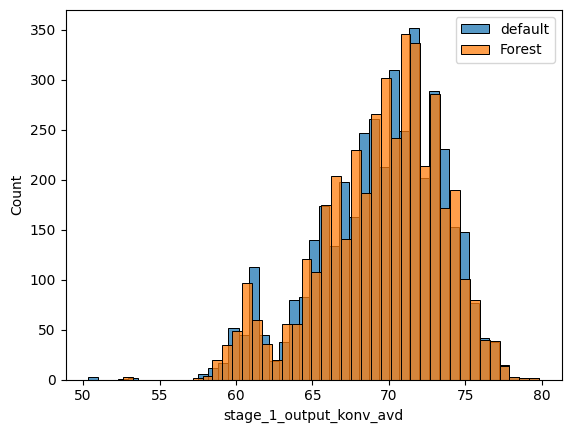

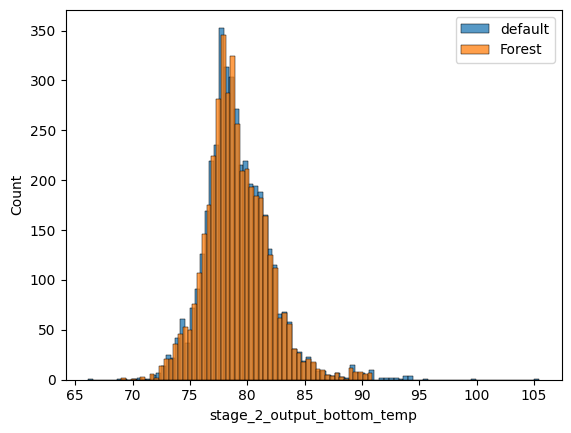

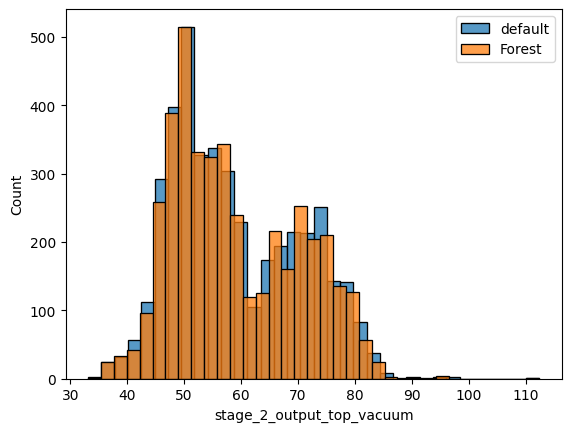

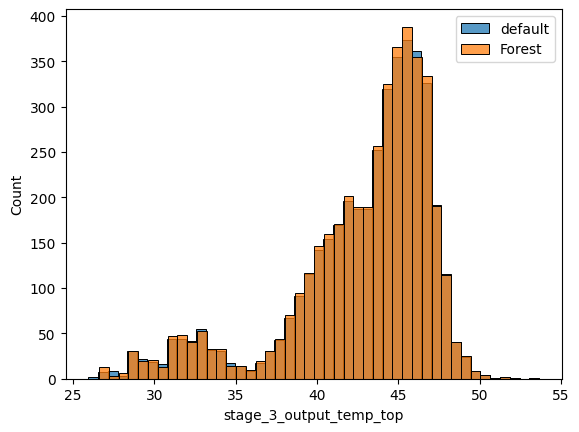

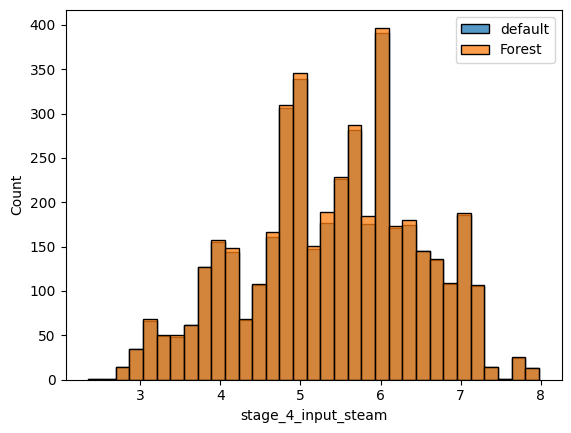

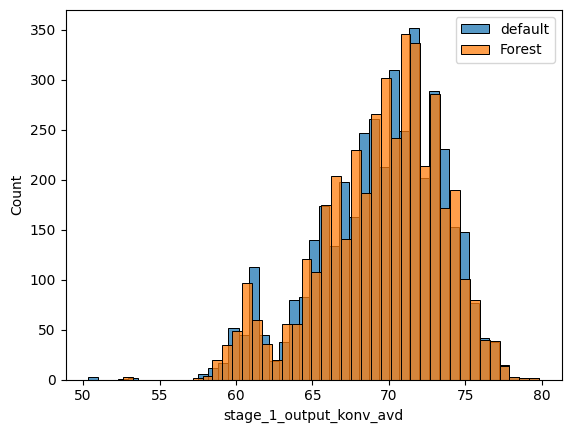

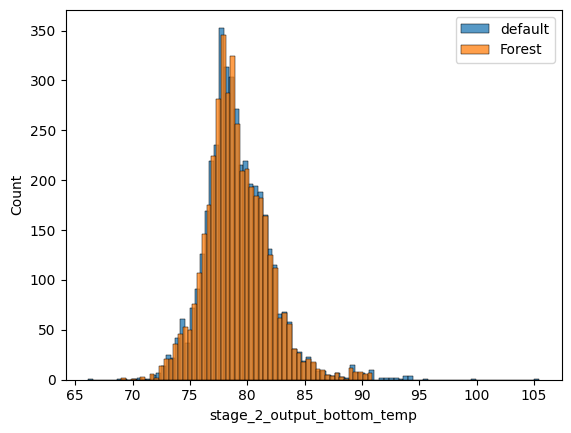

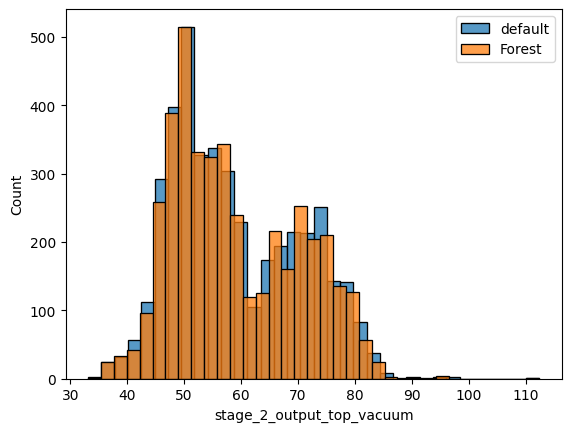

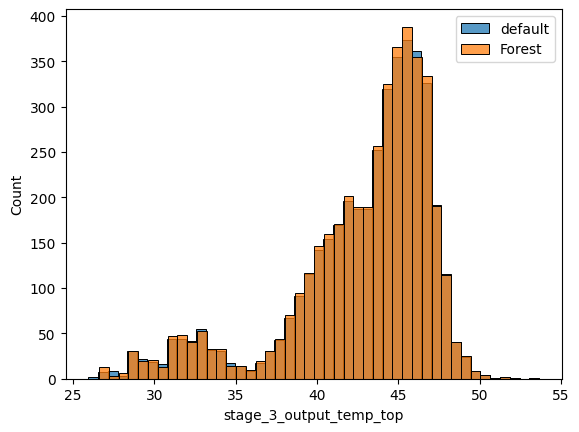

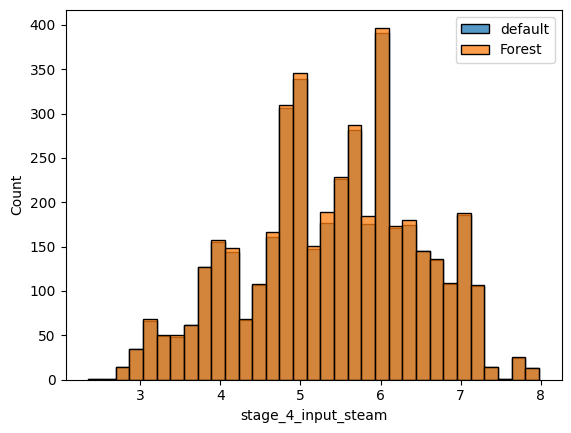

In [546]:
for column in columns_for_fill_nan: # закомментируй один из графиков, иначе ничего не будет понятно.
  sns.histplot(df4[column], label='default')
  sns.histplot(df[column], label='Forest')
  #sns.histplot(df2[column], label='Median')
  #sns.histplot(df3[column], label='Linear')
  plt.legend()
  plt.show()

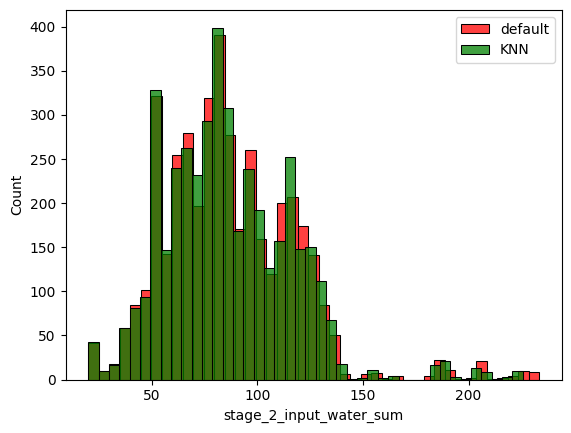

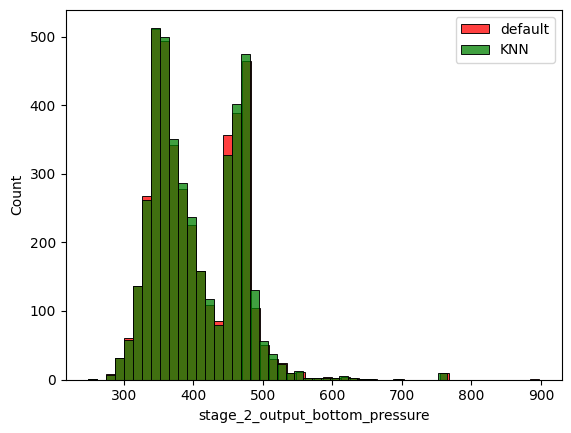

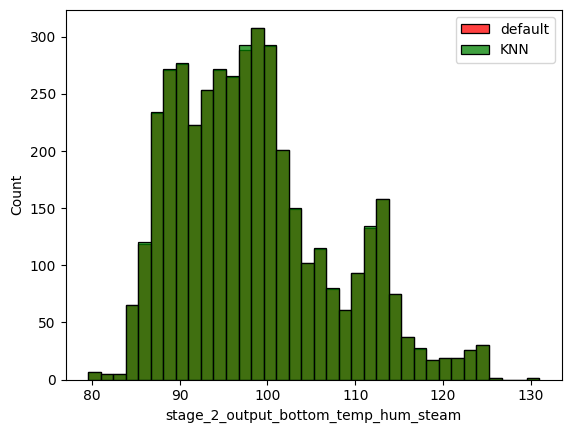

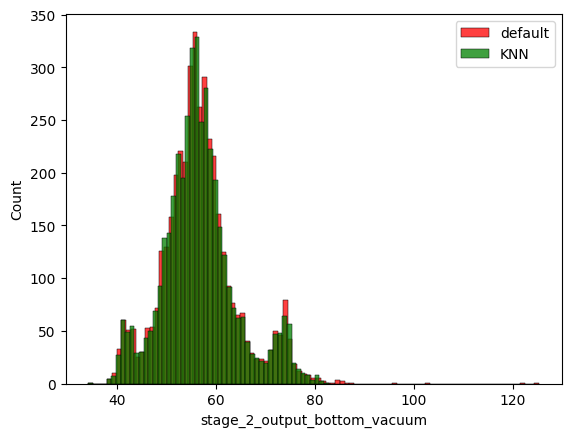

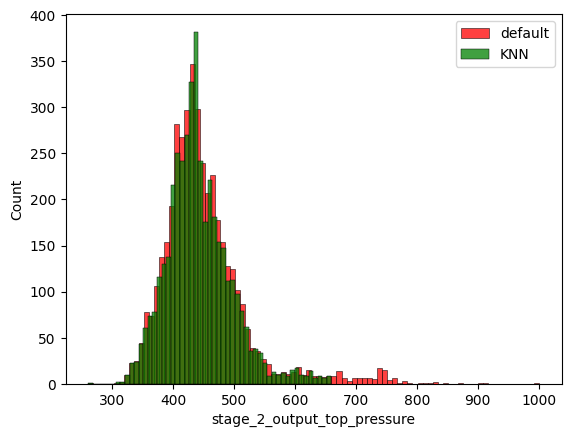

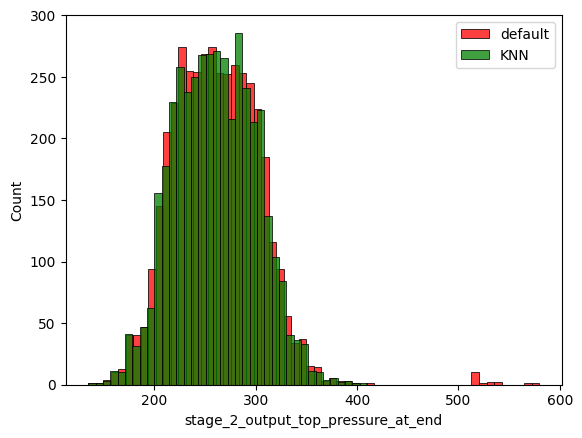

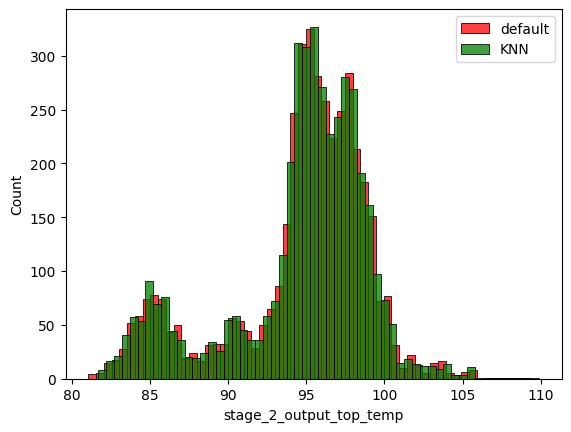

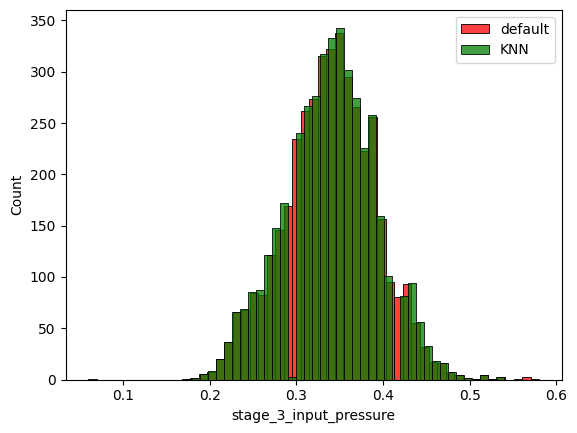

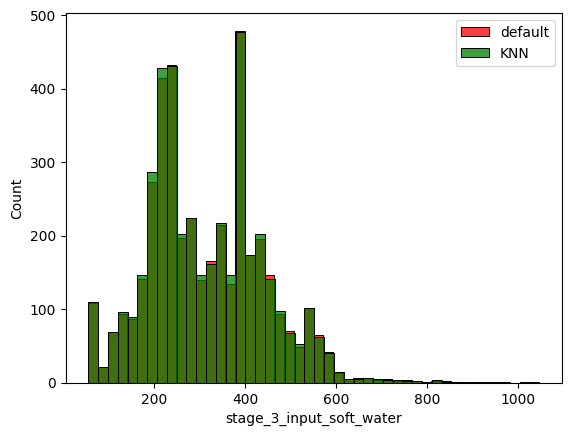

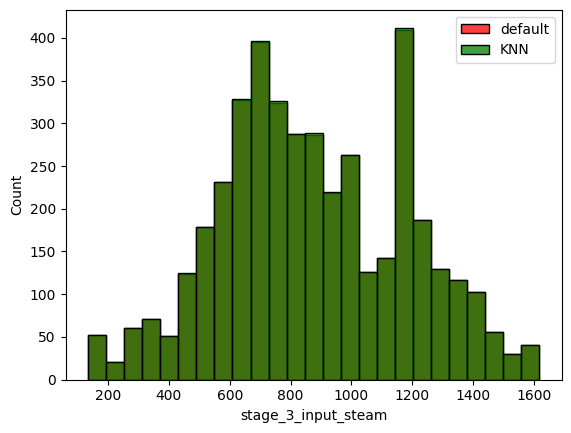

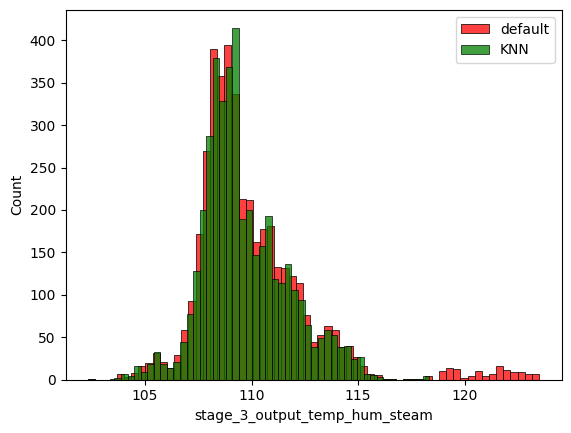

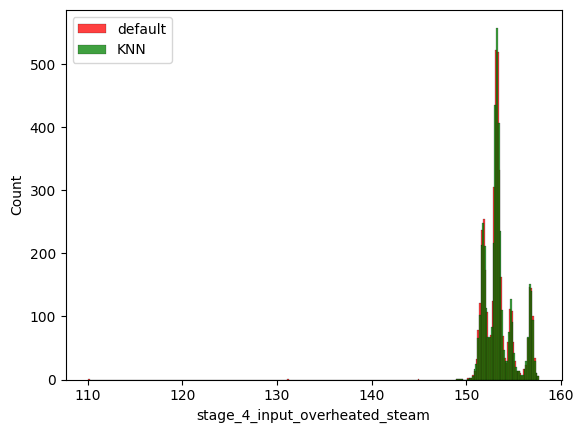

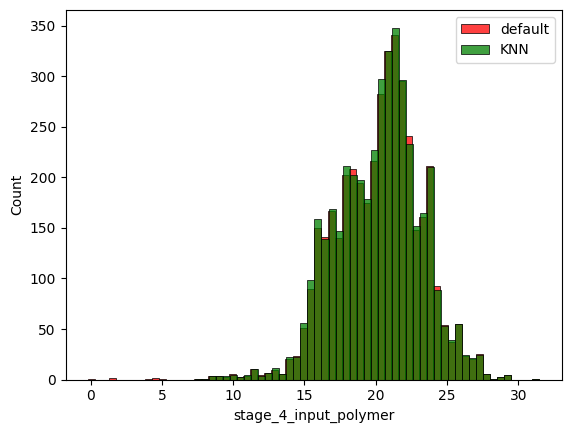

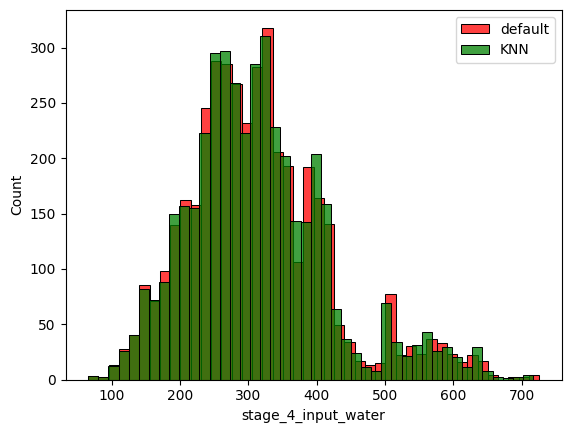

In [547]:
for column in df.columns: # закомментируй один из графиков, иначе ничего не будет понятно.
  if column not in columns_for_fill_nan and column not in columns_without_nan:
    sns.histplot(df4[column], label='default', color='RED')
    sns.histplot(df[column], label='KNN', color="GREEN")
    #sns.histplot(df2[column], label='Median')
    #sns.histplot(df3[column], label='Linear')
    plt.legend()
    plt.show()

# Как интегрировать это чюдо в свой код

Насколько я понимаю, вам достаточно скопировать всё эти махинации в самое начало вашего блокнота и после последней строчки моего кода написать
"название вашей переменной с датафреймом" = df


In [547]:
#my_data = df

А как буд-то мы можем себя возомнить гениями и в итоговом проекте сделать отдельный скрипт с этим кодом, который будет записывать в файлик csv Датафрейм без пропусков(или использовать данный скрипт как библиотеку и написать здесь функцию, которая будет возвращать обработанный дата фрейм).